This notebook shows how BigBang can help you analyze the senders in a particular mailing list archive.

First, use this IPython magic to tell the notebook to display matplotlib graphics inline. This is a nice way to display results.

In [4]:
%matplotlib inline

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

In [5]:
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import imp
imp.reload(process)

<module 'bigbang.process' from '/home/lem/Data/bigbang/bigbang/process.pyc'>

Also, let's import a number of other dependencies we'll use later.

In [6]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os

pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options

OptionError: 'You can only set the value of existing options'

Now let's load the data for analysis.

In [7]:
from bigbang.archive import load as load_archive
urls = ["http://mm.icann.org/pipermail/wp4/"]
try:
    arch_paths =[]
    for url in urls:
        arch_paths.append('../archives/'+url[:-1].replace('://','_/')+'.csv')
    archives = [load_archive(arch_path).data for arch_path in arch_paths]
except:
    arch_paths =[]
    for url in urls:
        arch_paths.append('../archives/'+url[:-1].replace('//','/')+'.csv')
    archives = [load_archive(arch_path).data for arch_path in arch_paths]
archives = pd.concat(archives)
activities = Archive(archives).get_activity()

IOError: File ../archives/http:/mm.icann.org/pipermail/wp4.csv does not exist

In [21]:

icann_path = "../archives/http:/mm.icann.org/pipermail"
ncuc_path = "../archives/http:/lists.ncuc.org/pipermail"

'''
paths = [os.path.join(icann_path,"ipc-gnso.csv"),
        os.path.join(icann_path,"wp4.csv"),
        os.path.join(icann_path,"alac.csv"),
        os.path.join(icann_path,"gnso-rds-pdp-wg.csv"),
        os.path.join(icann_path,"accountability-cross-community.csv"),
        os.path.join(icann_path,"cc-humanrights.csv"),
        os.path.join(ncuc_path,"ncuc-discuss.csv")]
'''

path = [os.path.join(ncuc_path,"ncuc-discuss.csv")]

datas = [load_archive(path).data for path in paths]
         
arx = Archive(pd.concat(datas))
activities = arx.get_activity()

In [22]:
a  = activities
ta = a.sum(0) # sum along the first axis
ta.sort()

/home/sb/anaconda/envs/nllz/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


In [23]:
levdf = process.sorted_matrix(a) # creates a slightly more nuanced edit distance matrix
                                 # and sorts by rows/columns that have the best candidates


In [37]:
import re

ren = "([\w\+\.\-]+(\@| at )[\w+\.\-]*) \((.*)\)"

matches = levdf < 4

def name_match(row):
    match = row[0]
    matches = [item[0] for item in row[1].items() if item[1]]
    name = re.match(ren,matches[0]).groups()[2]
    
    return (name,match)

m = pd.Series({nm[1] : nm[0] 
               for nm in 
               [name_match(row) for row in matches.iterrows()]})
    
m.to_csv("entity_matches.csv") 

In [ ]:
consolidates = []

# gather pairs of names which have a distance of less than 10
for col in levdf.columns:
  for index, value in levdf.loc[levdf[col] < 10, col].items():
        if index != col: # the name shouldn't be a pair for itself
            consolidates.append((col, index))
  
print(str(len(consolidates)) + ' candidates for consolidation.')

In [ ]:
c = process.consolidate_senders_activity(a, consolidates)
print('We removed: ' + str(len(a.columns) - len(c.columns)) + ' columns.')
c

In [ ]:
c[1]["From"]

We can create the same color plot with the consolidated dataframe to see how the distribution has changed.

Of course, there are still some duplicates, mostly people who are using the same name, but with a different email address at an unrelated domain name. BUT THEY ARE LESS!

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


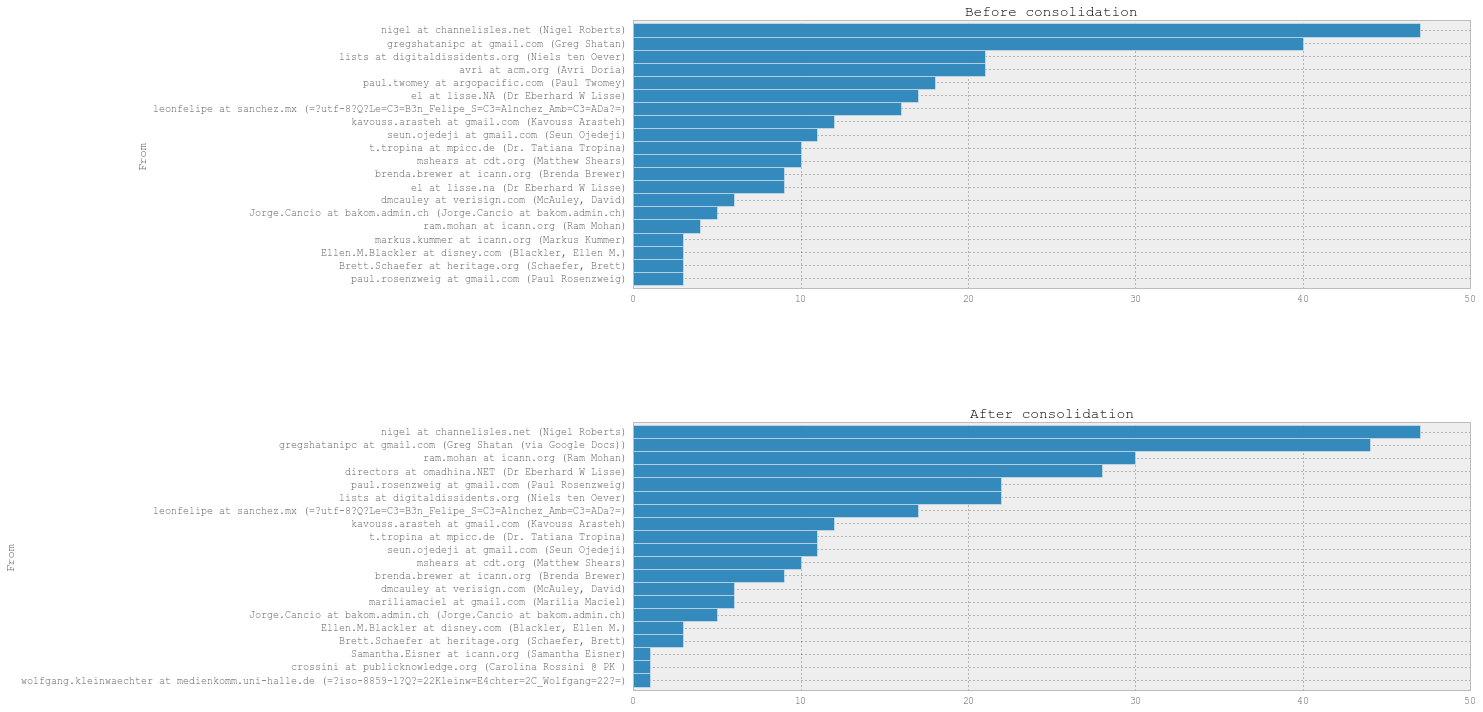

From
kimberly.carlson at icann.org (Kimberly Carlson)                                                                    1.0
turcotte.bernard at gmail.com (Bernard Turcotte)                                                                    1.0
stephanie.perrin at mail.utoronto.ca (Stephanie Perrin)                                                             1.0
vipul.kharbanda at gmail.com (Vipul Kharbanda)                                                                      1.0
gonzalo.navarro at icann.org (Gonzalo Navarro)                                                                      1.0
drive-shares-noreply at google.com (=?UTF-8?Q?Le=C3=B3n_Felipe_S=C3=A1nchez_Amb=C3=ADa_=28via_Google_Docs=29?=)     1.0
wolfgang.kleinwaechter at medienkomm.uni-halle.de (=?iso-8859-1?Q?=22Kleinw=E4chter=2C_Wolfgang=22?=)               1.0
crossini at publicknowledge.org (Carolina Rossini @ PK )                                                            1.0
Samantha.Eisner at icann.org (Saman

In [15]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 12))

ta = a.sum(0) # sum along the first axis
ta.sort()
ta[-20:].plot(kind='barh',ax=axes[0], width=1, title='Before consolidation')
tc = c.sum(0)
tc.sort()
tc[-20:].plot(kind='barh',ax=axes[1], width=1, title='After consolidation')
plt.show()
print(tc)

Okay, not dramatically different, but the consolidation makes the head heavier. There are more people close to that high end, a stronger core group and less a power distribution smoothly from one or two people.

We could also use sender email addresses as a naive inference for affiliation, especially for mailing lists where corporate/organizational email addresses are typically used.

Pandas lets us group by the results of a keying function, which we can use to group participants sending from email addresses with the same domain.

From
kimberly.carlson at icann.org (Kimberly Carlson)                                                                    1.0
turcotte.bernard at gmail.com (Bernard Turcotte)                                                                    1.0
stephanie.perrin at mail.utoronto.ca (Stephanie Perrin)                                                             1.0
vipul.kharbanda at gmail.com (Vipul Kharbanda)                                                                      1.0
gonzalo.navarro at icann.org (Gonzalo Navarro)                                                                      1.0
drive-shares-noreply at google.com (=?UTF-8?Q?Le=C3=B3n_Felipe_S=C3=A1nchez_Amb=C3=ADa_=28via_Google_Docs=29?=)     1.0
wolfgang.kleinwaechter at medienkomm.uni-halle.de (=?iso-8859-1?Q?=22Kleinw=E4chter=2C_Wolfgang=22?=)               1.0
crossini at publicknowledge.org (Carolina Rossini @ PK )                                                            1.0
Samantha.Eisner at icann.org (Saman

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


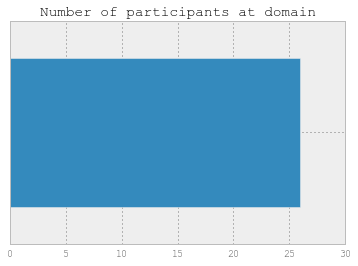

In [13]:
print(tc)
grouped = tc.groupby(process.domain_name_from_email)
domain_groups = grouped.size()
domain_groups.sort(ascending=True)
domain_groups[-20:].plot(kind='barh', width=1, title="Number of participants at domain")

We can also aggregate the number of messages that come from addresses at each domain. 

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


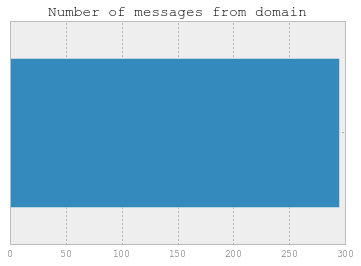

In [14]:
domain_messages_sum = grouped.sum()
domain_messages_sum.sort(ascending=True)
domain_messages_sum[-20:].plot(kind='barh', width=1, title="Number of messages from domain")

This shows distinct results from the participants and from the top individual contributors. For example, while there are many @gmail.com addresses among the participants, they don't send as many messages. Microsoft, Google and Mozilla (major browser vendors) send many messages to the list as a domain even though no individual from those organizations is among the top senders.